# -- START --

* If you have the libraries installed check the versions 
* If the libraries are missing or you have an older version then either install or update the library

In [1]:
# old versions

In [84]:
import matplotlib 
import pandas as pd
import scipy 
import statsmodels

print(f'''
Matplotlib -> {matplotlib.__version__}
pandas -> {pd.__version__}   
scipy -> {scipy.__version__}
statsmodels -> {statsmodels.__version__}
''')


Matplotlib -> 3.5.1
pandas -> 1.4.1   
scipy -> 1.7.3
statsmodels -> 0.11.1



In [85]:
# Pip install example
# !pip install matplotlib==3.5.0 pandas==1.3.4 scipy==1.7.3 statsmodels==0.11.1

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


import warnings


warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = 16, 3

### Create DataFrames 

In [259]:
file = Path("../../datasets/Ch8/nyc_taxi.csv")

nyc_taxi = pd.read_csv(file, 
                     index_col='timestamp', 
                     parse_dates=True)

In [260]:
nyc_taxi.index.freq = '30T'
nyc_taxi.index

DatetimeIndex(['2014-07-01 00:00:00', '2014-07-01 00:30:00',
               '2014-07-01 01:00:00', '2014-07-01 01:30:00',
               '2014-07-01 02:00:00', '2014-07-01 02:30:00',
               '2014-07-01 03:00:00', '2014-07-01 03:30:00',
               '2014-07-01 04:00:00', '2014-07-01 04:30:00',
               ...
               '2015-01-31 19:00:00', '2015-01-31 19:30:00',
               '2015-01-31 20:00:00', '2015-01-31 20:30:00',
               '2015-01-31 21:00:00', '2015-01-31 21:30:00',
               '2015-01-31 22:00:00', '2015-01-31 22:30:00',
               '2015-01-31 23:00:00', '2015-01-31 23:30:00'],
              dtype='datetime64[ns]', name='timestamp', length=10320, freq='30T')

In [268]:
def plot_outliers(outliers, data, method='KNN',
                 halignment = 'right', 
                 valignment = 'bottom',
                 labels=False):

    ax = data.plot(alpha=0.6)
    
    if labels:
        for i in outliers['value'].items():
            plt.plot(i[0], i[1], 'rx')
            plt.text(i[0], i[1], f'{i[0].date()}', 
                         horizontalalignment=halignment,
                         verticalalignment=valignment)
    else:
        data.loc[outliers.index].plot(ax=ax, style='rx')
        
    plt.title(f'NYC Taxi - {method}')
    plt.xlabel('date'); plt.ylabel('# of passengers')
    plt.legend(['nyc taxi','outliers'])
    plt.show()

### Visualize DataFrames

* **nyc_taxi.csv**: Number of NYC taxi passengers, where the five anomalies occur during the NYC marathon, Thanksgiving, Christmas, New Years day, and a snow storm. The raw data is from the NYC Taxi and Limousine Commission. The data file included here consists of aggregating the total number of taxi passengers into 30 minute buckets.
* **machine_temperature_system_failure.csv**: Temperature sensor data of an internal component of a large, industrial mahcine. The first anomaly is a planned shutdown of the machine. The second anomaly is difficult to detect and directly led to the third anomaly, a catastrophic failure of the machine.
* **Real time traffic data** from the Twin Cities Metro area in Minnesota, collected by the Minnesota Department of Transportation. Included metrics include occupancy, speed, and travel time from specific sensors.

In [90]:
nyc_taxi.index

DatetimeIndex(['2014-07-01 00:00:00', '2014-07-01 00:30:00',
               '2014-07-01 01:00:00', '2014-07-01 01:30:00',
               '2014-07-01 02:00:00', '2014-07-01 02:30:00',
               '2014-07-01 03:00:00', '2014-07-01 03:30:00',
               '2014-07-01 04:00:00', '2014-07-01 04:30:00',
               ...
               '2015-01-31 19:00:00', '2015-01-31 19:30:00',
               '2015-01-31 20:00:00', '2015-01-31 20:30:00',
               '2015-01-31 21:00:00', '2015-01-31 21:30:00',
               '2015-01-31 22:00:00', '2015-01-31 22:30:00',
               '2015-01-31 23:00:00', '2015-01-31 23:30:00'],
              dtype='datetime64[ns]', name='timestamp', length=10320, freq=None)

In [91]:
nyc_dates = [  "2014-10-30 15:30:00.000000",
            "2014-11-03 22:30:00.000000",
            "2014-11-25 12:00:00.000000",
            "2014-11-29 19:00:00.000000",
            "2014-12-23 11:30:00.000000",
            "2014-12-27 18:30:00.000000",
            "2014-12-29 21:30:00.000000",
            "2015-01-03 04:30:00.000000",
            "2015-01-24 20:30:00.000000",
            "2015-01-29 03:30:00.000000"]
pd.DataFrame(nyc_dates, columns=['actual']).sort_values('actual')

,actual
0,2014-10-30 15:30:00.000000
1,2014-11-03 22:30:00.000000
2,2014-11-25 12:00:00.000000
3,2014-11-29 19:00:00.000000
4,2014-12-23 11:30:00.000000
5,2014-12-27 18:30:00.000000
6,2014-12-29 21:30:00.000000
7,2015-01-03 04:30:00.000000
8,2015-01-24 20:30:00.000000
9,2015-01-29 03:30:00.000000


In [110]:
# nyc_dates =  [
#         "2014-11-01 19:00:00.000000",
#         "2014-11-27 15:30:00.000000",
#         "2014-12-25 15:00:00.000000",
#         "2015-01-01 01:00:00.000000",
#         "2015-01-27 00:00:00.000000"
# ]

In [236]:
nyc_dates =  [
        "2014-11-01",
        "2014-11-27",
        "2014-12-25",
        "2015-01-01",
        "2015-01-27"
]

<AxesSubplot:title={'center':'NYC Taxi'}, xlabel='timestamp'>

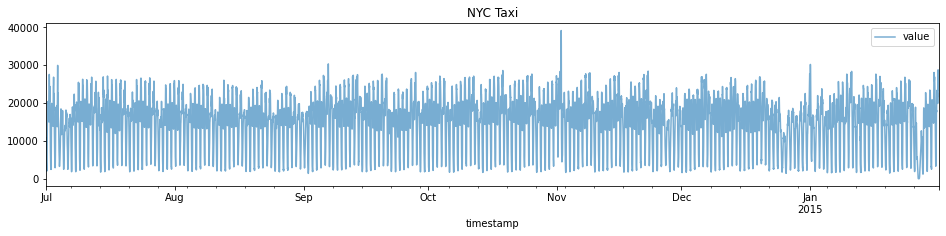

In [245]:
nyc_taxi.plot(title="NYC Taxi", alpha=0.6)

In [262]:
nyc_taxi.index.freq = '30T'

In [263]:
nyc_taxi.index

DatetimeIndex(['2014-07-01 00:00:00', '2014-07-01 00:30:00',
               '2014-07-01 01:00:00', '2014-07-01 01:30:00',
               '2014-07-01 02:00:00', '2014-07-01 02:30:00',
               '2014-07-01 03:00:00', '2014-07-01 03:30:00',
               '2014-07-01 04:00:00', '2014-07-01 04:30:00',
               ...
               '2015-01-31 19:00:00', '2015-01-31 19:30:00',
               '2015-01-31 20:00:00', '2015-01-31 20:30:00',
               '2015-01-31 21:00:00', '2015-01-31 21:30:00',
               '2015-01-31 22:00:00', '2015-01-31 22:30:00',
               '2015-01-31 23:00:00', '2015-01-31 23:30:00'],
              dtype='datetime64[ns]', name='timestamp', length=10320, freq='30T')

In [264]:
tx = nyc_taxi.resample('D').mean()

In [266]:
outliers = tx.loc[nyc_dates]

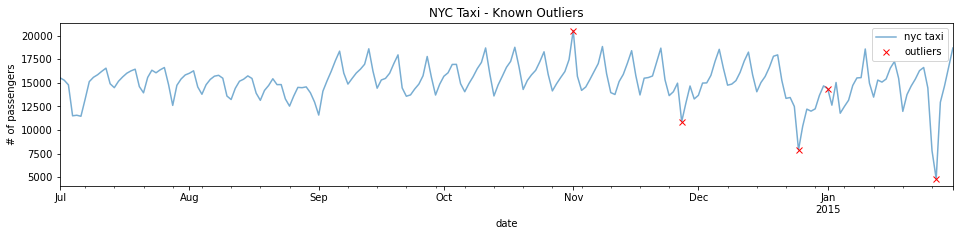

In [271]:
plot_outliers(outliers, tx, 'Known Outliers')

# Resampling Time Series Data

In [118]:
nyc_taxi.head()

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210
2014-07-01 01:30:00,4656
2014-07-01 02:00:00,3820


In [58]:
df_downsampled = nyc_taxi.resample('D').mean()
df_downsampled.head()

,value
timestamp,
2014-07-01,15540.979167
2014-07-02,15284.166667
2014-07-03,14794.625000
2014-07-04,11511.770833
2014-07-05,11572.291667


In [59]:
df_downsampled.index[0]

Timestamp('2014-07-01 00:00:00', freq='D')

In [60]:
df_downsampled.index.freq

<Day>

In [61]:
df_downsampled.shape

(215, 1)

In [12]:
df_downsampled = machine_temp.resample('3D').sum()
df_downsampled.head()

,value
timestamp,
2013-12-02,50382.133560
2013-12-05,70382.125169
2013-12-08,59704.334577
2013-12-11,81755.895600
2013-12-14,73672.877837


In [13]:
df_downsampled.shape

(27, 1)

In [14]:
df_downsampled.index.freq

<3 * Days>

In [15]:
df_downsampled = machine_temp.resample('3B', origin='end_day').sum()
df_downsampled.head(10)

,value
timestamp,
2013-12-02,2648.780734
2013-12-05,68467.848665
2013-12-10,109351.963907
2013-12-13,81755.895600
2013-12-18,128852.422076
2013-12-23,133261.059602
2013-12-26,78367.111514
2013-12-31,125032.813642
2014-01-03,79084.584271


In [16]:
nyc_taxi.resample('15T').mean().head()

,value
timestamp,
2014-07-01 00:00:00,10844.0
2014-07-01 00:15:00,NaN
2014-07-01 00:30:00,8127.0
2014-07-01 00:45:00,NaN
2014-07-01 01:00:00,6210.0


In [17]:
nyc_taxi.resample('15T').fillna('ffill').head()

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:15:00,10844
2014-07-01 00:30:00,8127
2014-07-01 00:45:00,8127
2014-07-01 01:00:00,6210


In [18]:
nyc_taxi.resample('15T').ffill().head()

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:15:00,10844
2014-07-01 00:30:00,8127
2014-07-01 00:45:00,8127
2014-07-01 01:00:00,6210


## There is more

In [19]:
nyc_taxi.resample('MS').agg(['mean', 'min', 
                            'max', 'median', 'sum'])

value                                
                    mean   min    max   median       sum
timestamp                                               
2014-07-01  14994.084677  1769  29985  16625.5  22311198
2014-08-01  14580.438844  1841  26062  16184.0  21695693
2014-09-01  15623.374306  1431  30373  17244.5  22497659
2014-10-01  16086.851478  1691  28626  17767.5  23937235
2014-11-01  15492.125000  1683  39197  17287.0  22308660
2014-12-01  14813.428763  1459  27804  16587.0  22042382
2015-01-01  14399.790995     8  30236  16061.0  21426889

# Detecting Outliers using Visualization

### Histograms

In [272]:
import seaborn as sns
sns.__version__

'0.11.2'

In [361]:
outliers

,value
timestamp,
2014-11-01,20553.500000
2014-11-27,10899.666667
2014-12-25,7902.125000
2014-12-26,10397.958333
2015-01-26,7818.979167
2015-01-27,4834.541667


<AxesSubplot:ylabel='Count'>

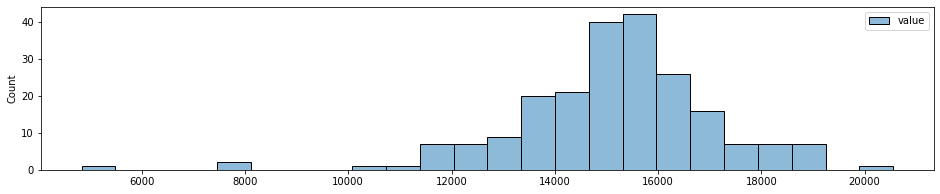

In [273]:
sns.histplot(tx)

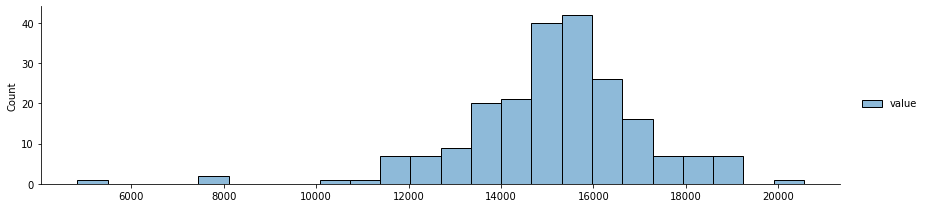

In [213]:
sns.displot(tx, kind='hist', height=3, aspect=4)

<AxesSubplot:xlabel='value'>

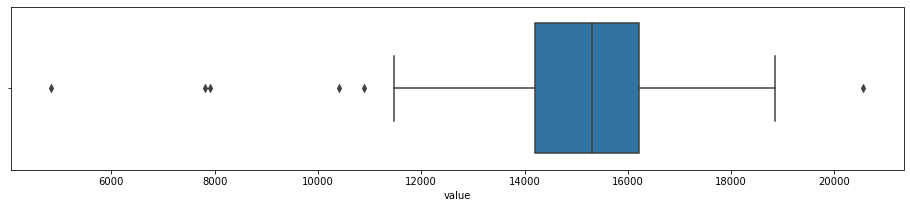

In [380]:
sns.boxplot(tx['value'], whis=1.5)

In [381]:
tx.describe()

,value
count,215.000000
mean,15137.569380
std,1937.391020
min,4834.541667
25%,14205.197917
50%,15299.937500
75%,16209.427083
max,20553.500000


<AxesSubplot:xlabel='value'>

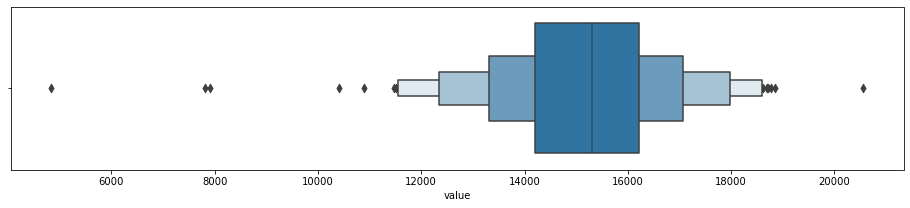

In [382]:
sns.boxenplot(tx['value'])

<AxesSubplot:xlabel='value'>

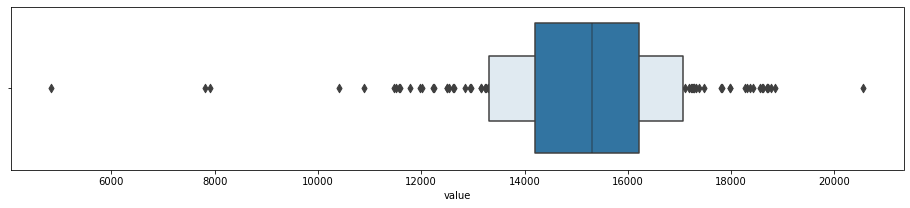

In [402]:
sns.boxenplot(tx['value'], k_depth=2)

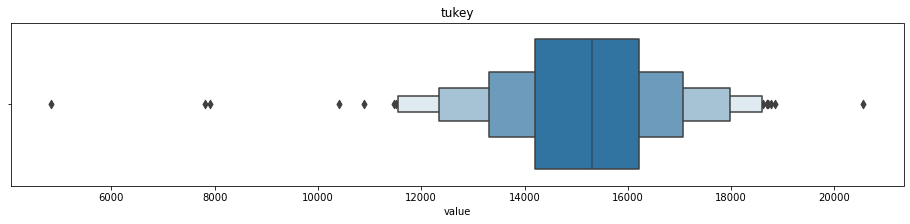

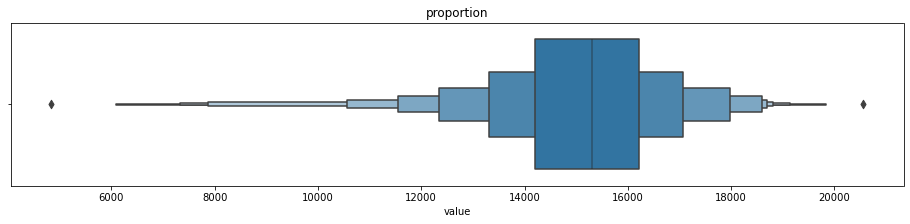

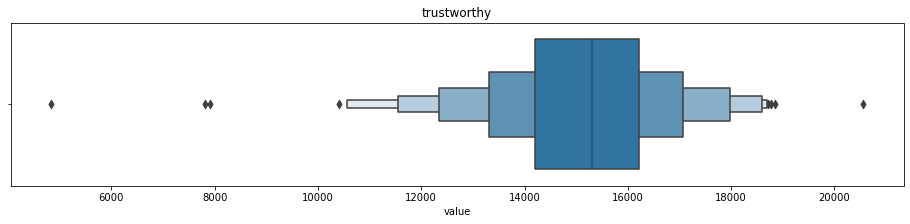

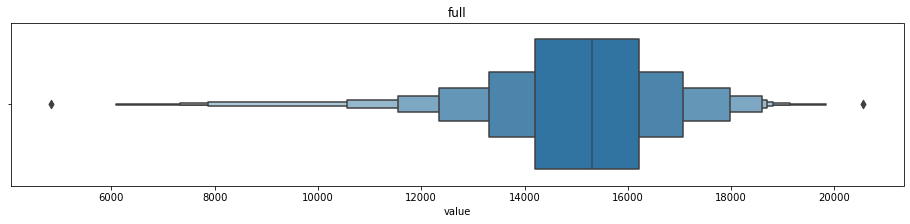

In [322]:
for k in ["tukey", "proportion", "trustworthy", "full"]:
    sns.boxenplot(tx['value'], k_depth=k)Ç
    plt.title(k)
    plt.show()

In [411]:
tx.describe()

,value
count,215.000000
mean,15137.569380
std,1937.391020
min,4834.541667
25%,14205.197917
50%,15299.937500
75%,16209.427083
max,20553.500000


<AxesSubplot:xlabel='value'>

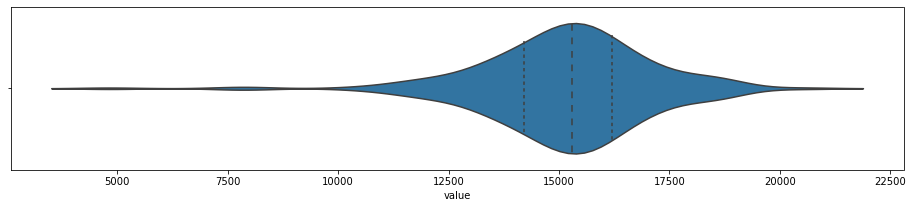

In [410]:
sns.violinplot(tx['value'], inner='quartile')

In [357]:
from pandas.plotting import lag_plot, autocorrelation_plot

In [362]:
outliers

,value
timestamp,
2014-11-01,20553.500000
2014-11-27,10899.666667
2014-12-25,7902.125000
2014-12-26,10397.958333
2015-01-26,7818.979167
2015-01-27,4834.541667


<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

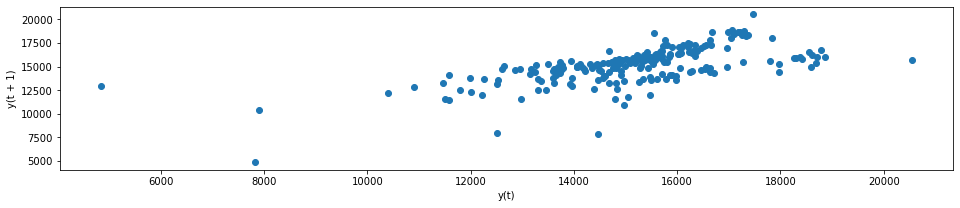

In [356]:
lag_plot(tx)

In [220]:
percentiles = [0.05, .10, .25, .5, .75, .90, .95]
stats = tx.describe(percentiles=percentiles)
stats

,value
count,215.000000
mean,15137.569380
std,1937.391020
min,4834.541667
5%,11998.181250
10%,13043.854167
25%,14205.197917
50%,15299.937500
75%,16209.427083
90%,17279.300000


### IQR 

In [277]:
def iqr_outliers(data):
    q1, q3 = np.percentile(data, [25, 75])
    IQR = q3 - q1
    lower_fence = q1 - (1.5 * IQR)
    upper_fence = q3 + (1.5 * IQR)
    return data[(data.value > upper_fence) | (data.value < lower_fence)]

In [278]:
iqr_outliers(tx)

,value
timestamp,
2014-11-01,20553.500000
2014-11-27,10899.666667
2014-12-25,7902.125000
2014-12-26,10397.958333
2015-01-26,7818.979167
2015-01-27,4834.541667


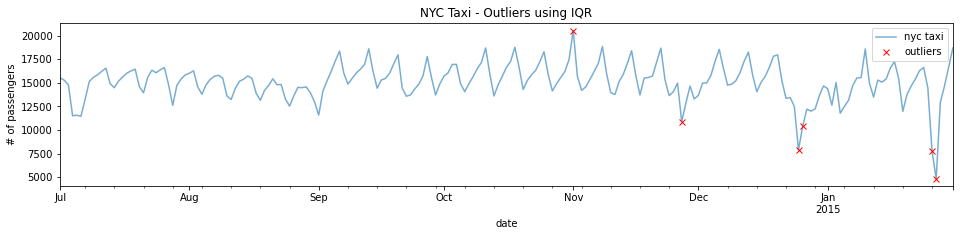

In [279]:
outliers = iqr_outliers(tx)
plot_outliers(outliers, tx, 'Outliers using IQR')

Z-Scores

$$
\Large z = \frac{x - \mu}{\sigma}
$$

In [157]:
def zscore(df, degree=3):
    data = df.copy()
    data['zscore'] = (data - data.mean())/data.std()
    
    return data[(data['zscore'] >= degree) | (data['zscore'] <= -degree)]['value'], data

In [169]:
threshold = 3
outliers, transformed = zscore(tx, threshold)

array([[<AxesSubplot:title={'center':'value'}>,
        <AxesSubplot:title={'center':'zscore'}>]], dtype=object)

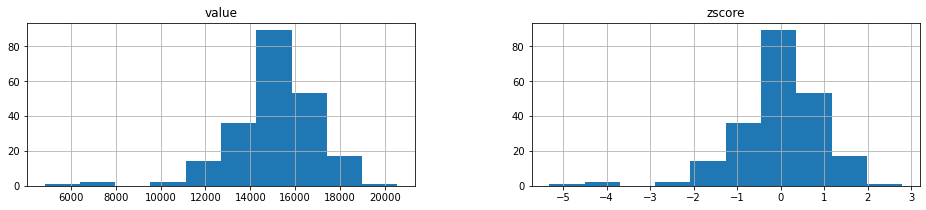

In [170]:
transformed.hist()

In [172]:
outliers

timestamp
2014-12-25    7902.125000
2015-01-26    7818.979167
2015-01-27    4834.541667
Name: value, dtype: float64

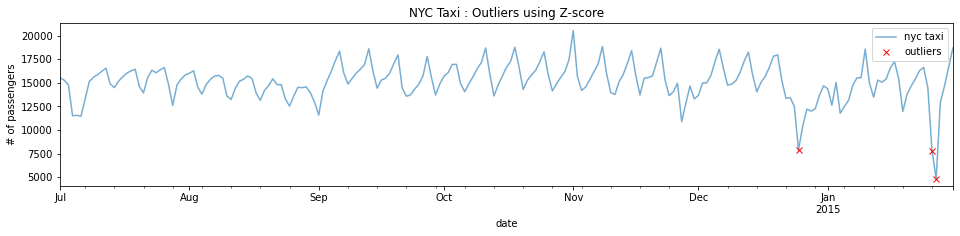

In [175]:
plot_outliers(outliers, tx, 'Outliers using Z-score')

### There is more

In [176]:
from statsmodels.stats.diagnostic import kstest_normal

def test_normal(df):
    t_test, p_value = kstest_normal(df)
    if p_value < 0.05:
        print("Reject null hypothesis. Data is not normal")
    else:
        print("Fail to reject null hypothesis. Data is normal")

In [177]:
test_normal(tx)

Reject null hypothesis. Data is not normal


# Modified Z-Score

In [178]:
import scipy.stats as stats
stats.norm.ppf(0.75)

0.6744897501960817

In [183]:
def modified_zscore(df, degree=3):
    data = df.copy()
    s = stats.norm.ppf(0.75)
    numerator = s*(data - data.median())
    denominator = np.abs(data - data.median()).median()
    data['m_zscore'] = numerator/denominator
    
    return data[(data['m_zscore'] > degree) | (data['m_zscore'] < -degree)]['value'], data

In [184]:
threshold = 3
outliers, transformed = modified_zscore(tx, threshold)

In [185]:
outliers.shape

(6,)

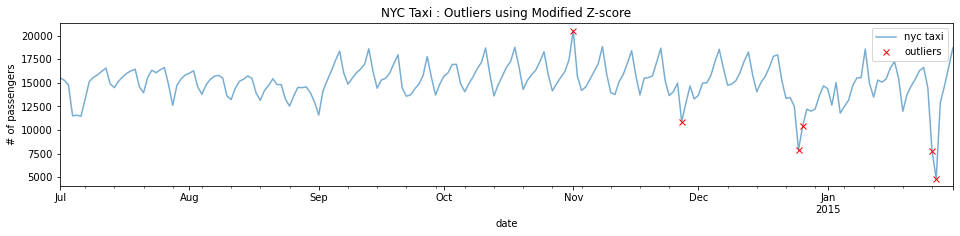

In [187]:
plot_outliers(outliers, tx, 'Outliers using Modified Z-score')

In [188]:
from statsmodels.tsa.seasonal import STL, seasonal_decompose

stl = STL(tx)
res = stl.fit()

<AxesSubplot:xlabel='timestamp'>

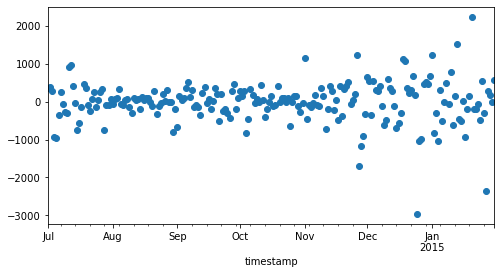

In [190]:
res.resid.plot(style='o', figsize=(8,4))

In [191]:
results = seasonal_decompose(tx, model='multiplicative')

<AxesSubplot:xlabel='timestamp'>

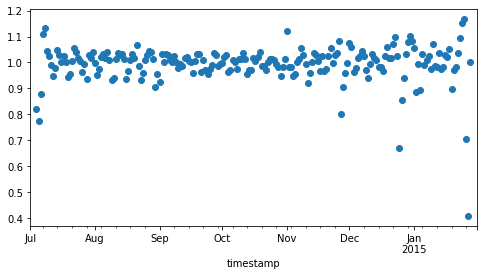

In [192]:
results.resid.plot(style='o', figsize=(8,4))

<AxesSubplot:xlabel='timestamp'>

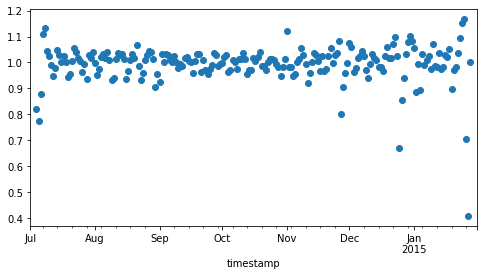

In [193]:
results.resid.plot(style='o', figsize=(8,4))

<AxesSubplot:xlabel='timestamp'>

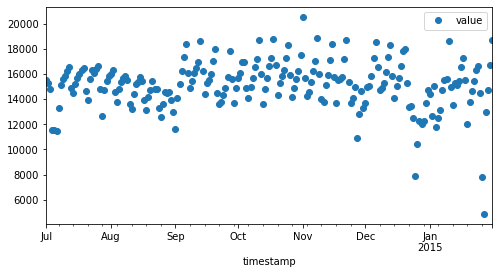

In [194]:
tx.plot(style='o', figsize=(8,4))